# Predicting stock prices using deep learning

**If a human investor can be successful, why can’t a machine?
**
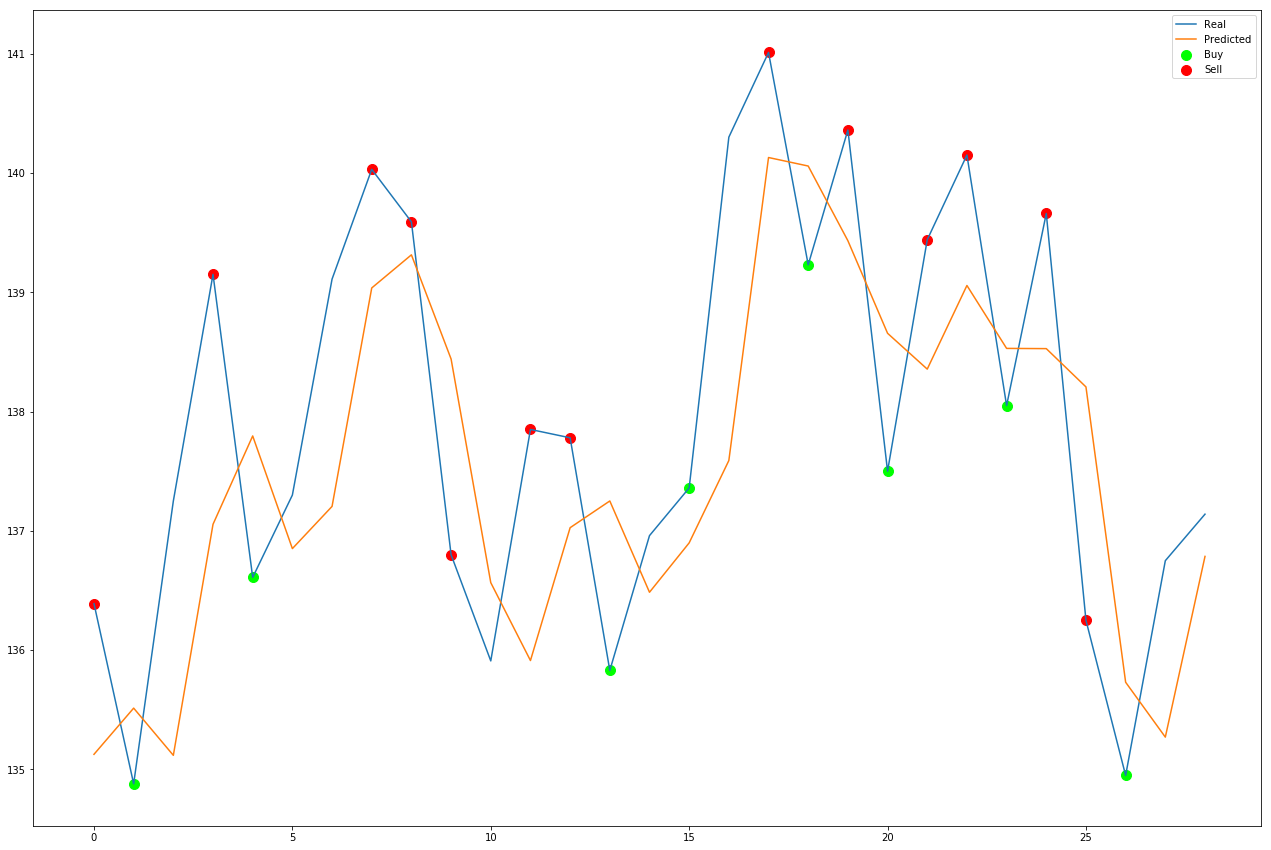
I would just like to add a disclaimer — this project is entirely intended for research purposes! I’m just a student learning about deep learning, and the project is a work in progress, please don’t put any money into it!

Algorithmic trading has revolutionised the stock market and its surrounding industry. Over 70% of all trades happening in the US right now are being handled by bots[1]. Gone are the days of the packed stock exchange with suited people waving sheets of paper shouting into telephones.

This got me thinking of how I could develop my own algorithm for trading stocks, or at least try to accurately predict them.

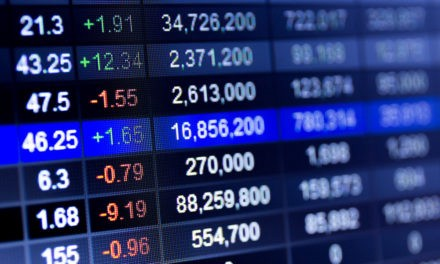
> Machines are great with numbers!


I’ve learned a lot about neural networks and machine learning over the summer and one of the most recent and applicable ML technologies I learnt about is the LSTM cell [2].
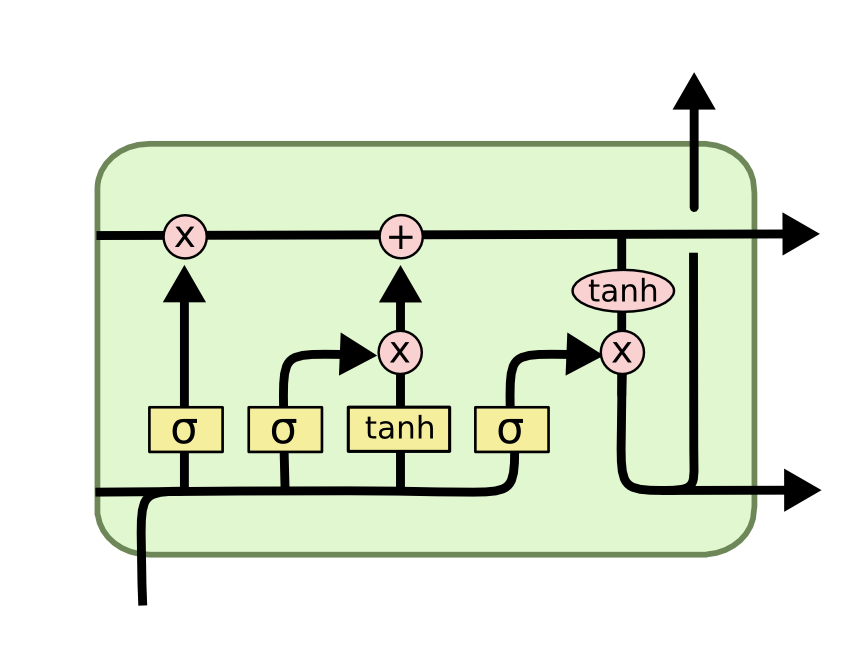
> An LSTM cell. Credit: https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Long Short Term Memory cells are like mini neural networks designed to allow for memory in a larger neural network. This is achieved through the use of a recurrent node inside the LSTM cell. This node has an edge looping back on itself with a weight of one, meaning at every feedfoward iteration the cell can hold onto information from the previous step, as well as all previous steps. Since the looping connection’s weight is one, old memories wont fade over time like they would in traditional RNNs.

LTSMs and recurrent neural networks are as a result good at working with time series data thanks to their ability to remember the past. By storing some of the old state in these recurrent nodes, RNNs and LSTMs can reason about current information as well as information the network had seen one, ten or a thousand steps ago. Even better, I don’t have to write my own implementation of an LSTM cell; [they’re a default layer in Tensorflow’s Keras.](https://keras.io/layers/recurrent/#lstm)

So I had my plan; to use LSTMs and Keras to predict the stock market, and perhaps even make some money.

# The Dataset

The good thing about stock price history is that it’s basically a well labelled pre formed dataset. After some googling I found a service called [pytse client](https://pypi.org/project/pytse-client/). They offered the daily price history of Tehran Stock Exchange for the past 19 years. This included the open, high, low, close, volume,etc of trades for each day, from today all the way back up to 1380. 

In [1]:
# import pytse_client as tse
# data = tse.download(symbols="فملی", write_to_csv=True)

# Preprocessing

## Data cleaning

For the stocks that had their IPO listing within the past 19 years, the first day of trading that stock often looked anomalous due to the massively high volume. This inflated max volume value also affected how other volume values in the dataset were scaled when normalising the data, so I opted to drop the oldest data points out of every set. I also drop the date since the model doesn’t need to know anything about when trades happened, all it needs is well ordered time series data.


## Train,validate, test data spliting

Well now I need to separate the training and test data. I dedicate 70% of the data to training, 15% to validation and the remaining 15% to testing.

## Data Standardization

Looking at the data, I will see that the data needs to be standardized. Standardization means that the range of values is the same for all attributes. There are several ways to standardize. One of these methods is to use the minimum and maximum data values.[3]

For our data, price range and trading volume are very different. Therefore, the data must be standardized. I will standardize using the minimum and maximum amount of data. To do this, I use the scikit-learn library and the preprocessing module.

For this purpose, first obtain the minimum and maximum training data using the command preprocessing.MinMaxScaler().fit. Then I standardize the test and training data with the help of Min and Max training data.

Note that I can not standardize validation and test data with their own Min and Max. If I do, I are actually cheating the network. Therefore, I standardize all data with Min and Max training data.

x_train_n,x_test_n and x_val_n now contain the normalised stock prices.

## Get ready for model consumption

I want to estimate the stock price when the market opens. In this project, I provide data for 50 days to the network and I want to estimate the opening price of the stock the next day. For this reason, I first separate the data into 50 slices. Here I also separate the openning price on the 51st day as a label. To do this, I write function slicing:

Then, using the function I wrote, I separate the training, validation, and test data by 50 to 50, and I also separate their labels.


The ohlvc_train list will be our x parameter when training the neural network. Each value in the list is a numpy array containing 50 open, high, low, volume and close going from oldest to newest. This is controlled by the history_points parameter, as seen inside the slice operation.

So for each x value I are getting the [i : i + history_points] stock prices (remember that numpy slicing is [inclusive:exclusive]), then the y value must be the singular [i + history_points] stock price; the stock price for the very next day.

Here I also have to choose what value I are intending on predicting. I decided to predict the open value for the next day, so I need to get the 1st (0 index) element of every ohlvc value in the data, hence **data_scaled[:,0]**.

There’s also a variable called scale_back to hold on to. This is used at the end of a prediction, where the model will spit out a normalised number between 0 and 1, I want to apply the reverse of the dataset normalisation to scale it back up to real world values. In the future I will also use this to compute the real world (un-normalised) error of our model.

Then to get the data working with Keras I make the y array 2-dimensional by way of np.expand_dims(). And finally I keep hold of the unscaled next day open values for plotting results later.

Just before returning the data I check that the number of x’s == the number of y’s.


In [18]:
import numpy as np
import pandas as pd
from sklearn import preprocessing


def preprocess(csv_path, history_points):
    data = pd.read_csv(csv_path)
    print(data.dtypes)
    print(data.head())
    
    data = data.drop(columns=['Date', 'Adj Close'])
    data = data.drop(0, axis=0)
    data_np = data.to_numpy()
    
    # Train-Test-Validation Split
    # 70% for train data
    # 15% for test data
    # 15% for validation data
    
    n1 = int(data_np.shape[0] * 0.7)
    n2 = int((data_np.shape[0] - n1) / 2)
    x_train = data_np[:n1]
    x_val = data_np[n1: n1 + n2]
    x_test = data_np[n1 + n2:]
    y_train_real = slicing(x_train, history_points)[1]
    y_train_real = np.expand_dims(y_train_real, -1)
    scale_back = preprocessing.MinMaxScaler()
    scale_back.fit(y_train_real)
    y_test_real = slicing(x_test, history_points)[1]

    minmax_scale = preprocessing.MinMaxScaler().fit(x_train)
    x_train_n = minmax_scale.transform(x_train)
    x_val_n = minmax_scale.transform(x_val)
    x_test_n = minmax_scale.transform(x_test)

    ohlvc_train, y_train = slicing(x_train_n, history_points)
    x_val_n, y_val = slicing(x_val_n, history_points)
    ohlvc_test, y_test = slicing(x_test_n, history_points)
    y_train = np.expand_dims(y_train, -1)

    assert ohlvc_train.shape[0] == y_train.shape[0] 
    return ohlvc_train, y_train, ohlvc_test, y_test, x_val_n, y_val, y_test_real, scale_back

# def slicing(data, history_points):
#     # using the last {history_points} open high low close volume data points, predict the next open value
#     ohlvc_histories = np.array(
#         [data[i: i + history_points].copy() for i in range(len(data) - history_points)])
#     next_day_open_values = np.array(
#         [data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])

#     return ohlvc_histories, next_day_open_values

def slicing(data, history_points):
    ohlvc_histories = np.array(
        [data[i: i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.array(
        [data[i + history_points, 0] for i in range(len(data) - history_points)])

    return ohlvc_histories, next_day_open_values

In [19]:
csv_path = 'data/NFLX_3.csv'
history_points = 50
x_train, y_train, x_test, y_test, x_val, y_val, y_test_real, scale_back = preprocess(csv_path, history_points)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
         Date      Open      High       Low     Close  Adj Close     Volume
0  2002-05-23  1.156429  1.242857  1.145714  1.196429   1.196429  104790000
1  2002-05-24  1.214286  1.225000  1.197143  1.210000   1.210000   11104800
2  2002-05-28  1.213571  1.232143  1.157143  1.157143   1.157143    6609400
3  2002-05-29  1.164286  1.164286  1.085714  1.103571   1.103571    6757800
4  2002-05-30  1.107857  1.107857  1.071429  1.071429   1.071429   10154200


Well, so far I have prepared training and test data. The next step is to define the model. So let's go to model definition.

# The Model
I started this project only knowing how to write sequential Keras code, but I ended up learning it’s functional API since I wanted a more complex network structure, eventually featuring two inputs with different layer types in each branch.

I’ll go over the most basic model that I came up with first.

The input layer has shape **(history_points, 5)**, since each input data point is an array shaped like [history_points × OHLVC]. The model has 50 LSTM cells in the first layer, a dropout layer to prevent overfitting and then some dense layers to bring all of the LSTM data together.
An important feature of this network is the linear output activation, allowing the model to tune its penultimate weights accurately.

# The Training
Well now I are training the network with training data. To do this, consider the batch size to be 32 and the number of iterations to be 50. I also shuffle the data order. With the help of call back, I save and use the model that has the least amount of loss for validation data.

# The Evaluation
To more accurately evaluate the model, let’s see how it predicts the test set in comparison with the real values. First I scale the predicted values up, then I compute the root mean squared error, but then to make the error relative to the dataset I divide it by the ‘spread’ of the test data — the max test data point minus the min.

In [20]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
from keras.callbacks import ModelCheckpoint

np.random.seed(4)
tf.random.set_seed(4)

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='mse')

# Fitting model
mcp_save = ModelCheckpoint('./stocks_price.keras', save_best_only=True, monitor='val_loss', mode='min')
model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_data=(x_val, y_val), callbacks=[mcp_save], verbose=0)
model.load_weights('./stocks_price.keras')

# Evaluate model (scaled data)
evaluation = model.evaluate(x_test, y_test)
print("Prediction Mean Squared Error for normalized data : {}".format(evaluation))

# Evaluate model (unscaled data)
y_test_predicted = model.predict(x_test)
y_test_predicted = scale_back.inverse_transform(y_test_predicted)
rmse = np.square(np.mean(y_test_real - y_test_predicted))
scaled_rmse = rmse / (np.max(y_test_real) - np.min(y_test_real)) * 100

print("Adjucted Prediction Root Mean Squared Error for real data : {} % ".format(scaled_rmse))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3657
Prediction Mean Squared Error for normalized data : 0.24523977935314178
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Adjucted Prediction Root Mean Squared Error for real data : 667.7459141554581 % 


Which gives us a model that looks like:


In [24]:
from keras.utils import plot_model
plot_model(model, to_file='model.v1.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [26]:
from keras.utils import plot_model

import pydot
if pydot.find_graphviz():
    print("Graphviz installation found.")
else:
    print("Graphviz installation not found.")


AttributeError: module 'pydot' has no attribute 'find_graphviz'

I got a final evaluation score of 0.006, which seems super low but remember that this is the mean squared error of the normalised data. After scaling this value will go up significantly, so it’s not a great metric for loss.

This gives us a root mean squared error of 718. Is that good? It’s not amazing, it means on average the predicted line deviates over 718% from the actual. Let’s see how it looks on a graph.

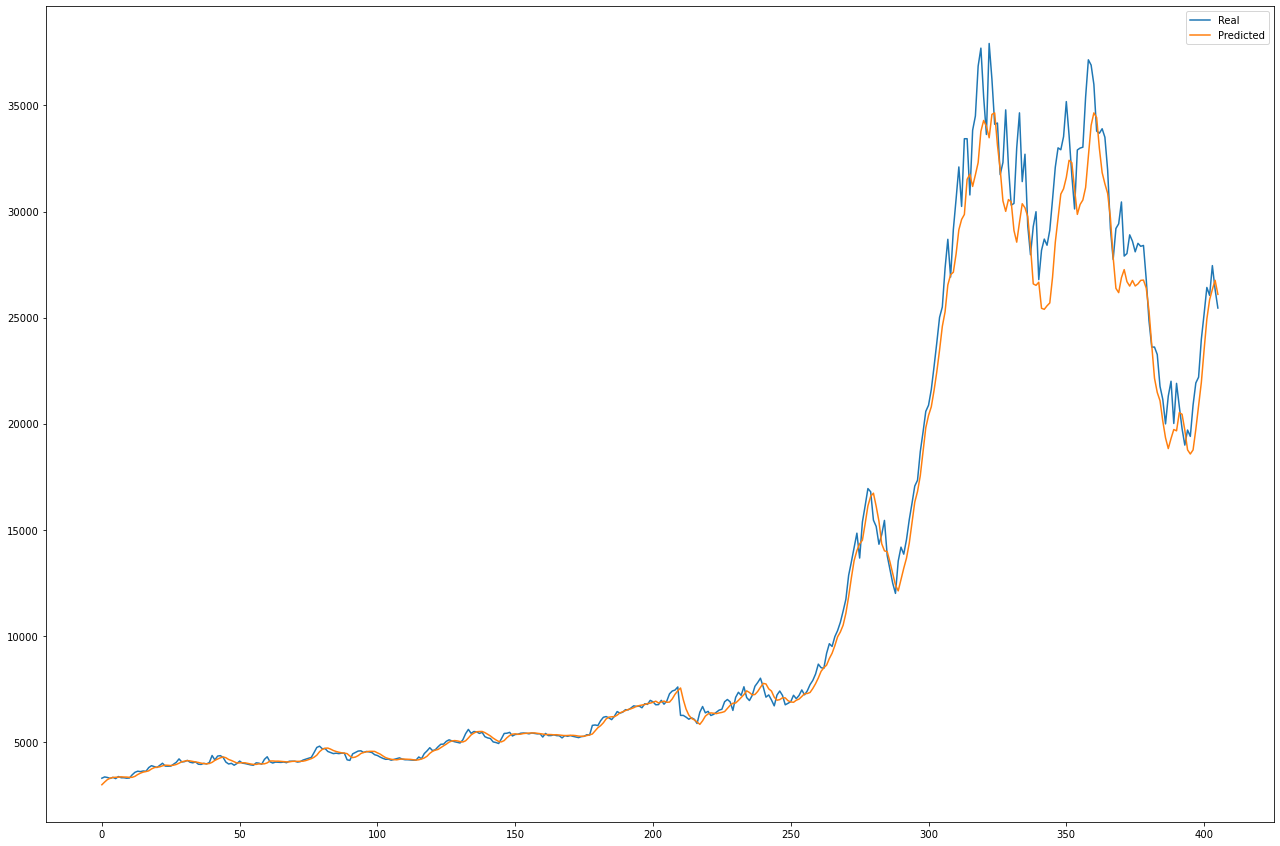

In [6]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

But not bad! I’m not sure why the predicted value is consistently lower than the actual value, maybe it’s something to do with the way the test and train sets are split.

# The Improvements
I could try to make our model more complex, and also increase the size of the dataset. Let’s start with trying to create a more complex model.
A common metric used by stock market analysts are technical indicators[4]. Technical indicators are math operations done on stock price history, and are traditionally used as visual aids to help identify the direction the market is going to change in. I can augment our model to accept these technical indicators through a secondary input branch.
For now let’s use only the simple moving average SMA indicator as an extra input into our network.
To calculate the simple moving average of a stock, simply take the average of the stock’s opening, high and low price over the past n time steps[5]. This works great for us, since I are already dealing with fixed timestep blocks of price history. To include the SMA in our model I will have to change our dataset handling code.

In [7]:
import numpy as np
import pandas as pd
from sklearn import preprocessing


def preprocess(csv_path, history_points):
    data = pd.read_csv(csv_path)
    data = data.drop(columns=['date', 'adjClose', 'value', 'count'])
    data = data.drop(0, axis=0)
    data_np = data.to_numpy()
    """
    Train-Test-Validation Split
    """
    n1 = int(data_np.shape[0] * 0.7)
    n2 = int((data_np.shape[0] - n1) / 2)
    x_train = data_np[:n1]
    x_val = data_np[n1: n1 + n2]
    x_test = data_np[n1 + n2:]
    y_train_real = slicing(x_train, history_points)[1]
    y_train_real = np.expand_dims(y_train_real, -1)
    scale_back = preprocessing.MinMaxScaler()
    scale_back.fit(y_train_real)
    y_test_real = slicing(x_test, history_points)[1]

    minmax_scale = preprocessing.MinMaxScaler().fit(x_train)
    x_train_n = minmax_scale.transform(x_train)
    x_val_n = minmax_scale.transform(x_val)
    x_test_n = minmax_scale.transform(x_test)

    ohlvc_train, y_train = slicing(x_train_n, history_points)
    x_val_n, y_val = slicing(x_val_n, history_points)
    ohlvc_test, y_test = slicing(x_test_n, history_points)
    y_train = np.expand_dims(y_train, -1)

    """
    Technical Indicators
    """
    x_train_ind = slicing(x_train, history_points)[0]
    tech_ind_train = []
    for his in x_train_ind:
        # since I'm using his[1,2,4],I'm taking the SMA of the high, low ,closing price
        sma = np.mean(his[:, [1, 2, 4]])
        tech_ind_train.append(np.array([sma]))

    x_test_ind = slicing(x_test, history_points)[0]
    tech_ind_test = []
    for his in x_test_ind:
        sma = np.mean(his[:, [1, 2, 4]])
        tech_ind_test.append(np.array([sma]))

    x_val_ind = slicing(x_val, history_points)[0]
    tech_ind_val = []
    for his in x_val_ind:
        sma = np.mean(his[:, [1, 2, 4]])
        tech_ind_val.append(np.array([sma]))

    tech_ind_scaler = preprocessing.MinMaxScaler().fit(tech_ind_train)
    tech_ind_train = tech_ind_scaler.transform(tech_ind_train)
    tech_ind_test = tech_ind_scaler.transform(tech_ind_test)
    tech_ind_val = tech_ind_scaler.transform(tech_ind_val)

    tech_ind_train = np.array(tech_ind_train)
    tech_ind_test = np.array(tech_ind_test)
    tech_ind_val = np.array(tech_ind_val)

    assert ohlvc_train.shape[0] == y_train.shape[0] == tech_ind_train.shape[0]
    return ohlvc_train, y_train, ohlvc_test, y_test, x_val_n, y_val, y_test_real, scale_back, tech_ind_train, tech_ind_test, tech_ind_val


def slicing(data, history_points):
    # using the last {history_points} open high low close volume data points, predict the next open value
    ohlvc_histories = np.array(
        [data[i: i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.array(
        [data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])

    return ohlvc_histories, next_day_open_values

In [8]:
csv_path = '../input/national-iranian-copper-industries-co-stocks/femeli-daily.csv'
history_points = 50

x_train, y_train, x_test, y_test, x_val, y_val, y_test_real, scale_back, tech_ind_train, tech_ind_test, tech_ind_val = preprocess(
        csv_path, history_points)

This happens just after I have defined the ohlvc_histories and next_day_open_values arrays. I loop across every 50-price block of data and calculate the mean of the high, low, close column, and add that value to a technical_indicators list. The list then goes through the same transformations as the rest of the data, being scaled to fit within the values 0 to 1. I then change the return statement to return the technical indicators, as well as the other stuff I returned from before.
Now to augment the model to match this new dataset. I want to be able to use our old LSTM structure, but incorporate the SMA technical indicator somewhere in the mix. Since the SMA is not a time-series piece of data I shouldn’t pass it through the LSTM. Instead I should mix it in before the final prediction is made; I should input it into the penultimate 64-node dense layer. So I will need a model with two inputs, a concatenation layer and one output.

Note how I used tech_ind_train.shape[1] as the input shape for the tech_input layer. This means that any new technical indicators I add will fit in just fine when I recompile the model.
The evaluation code has to be changed to match this dataset change as well.

I pass in a list of [ohlvc, technical_indicators] as the input to our model. This order matches the way I defined our model’s input.

In [9]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
from keras.callbacks import ModelCheckpoint

np.random.seed(4)

tf.random.set_seed(4)

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(tech_ind_train.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch operates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.v2.png', show_shapes=True)

# Fitting model
mcp_save = ModelCheckpoint('./stocks_price.h5', save_best_only=True, monitor='val_loss', mode='min')

model.fit(x=[x_train,tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True,validation_data=([x_val, tech_ind_val], y_val), callbacks=[mcp_save], verbose=0)
model.load_weights('./stocks_price.h5')

# Evaluate model (scaled data)
evaluation = model.evaluate([x_test, tech_ind_test], y_test)
print("Prediction Error for normalized data : {}".format(evaluation))

# Evaluate model (unscaled data)
y_test_predicted = model.predict([x_test, tech_ind_test])
y_test_predicted = scale_back.inverse_transform(y_test_predicted)
rmse = np.square(np.mean(y_test_real - y_test_predicted))
scaled_rmse = rmse / (np.max(y_test_real) - np.min(y_test_real)) * 100

print("Adjucted Prediction Root Mean Squared Error for real data : {} % ".format(scaled_rmse))

13/13 [==============================] - 0s 3ms/step - loss: 0.0050
Prediction Error for normalized data : 0.005032062530517578
Adjucted Prediction Root Mean Squared Error for real data : 413.053141022933 % 


And I get an adjusted mean squared error of 413%! Much lower, and the prediction appears to fit significantly closer to the test set when plotted:

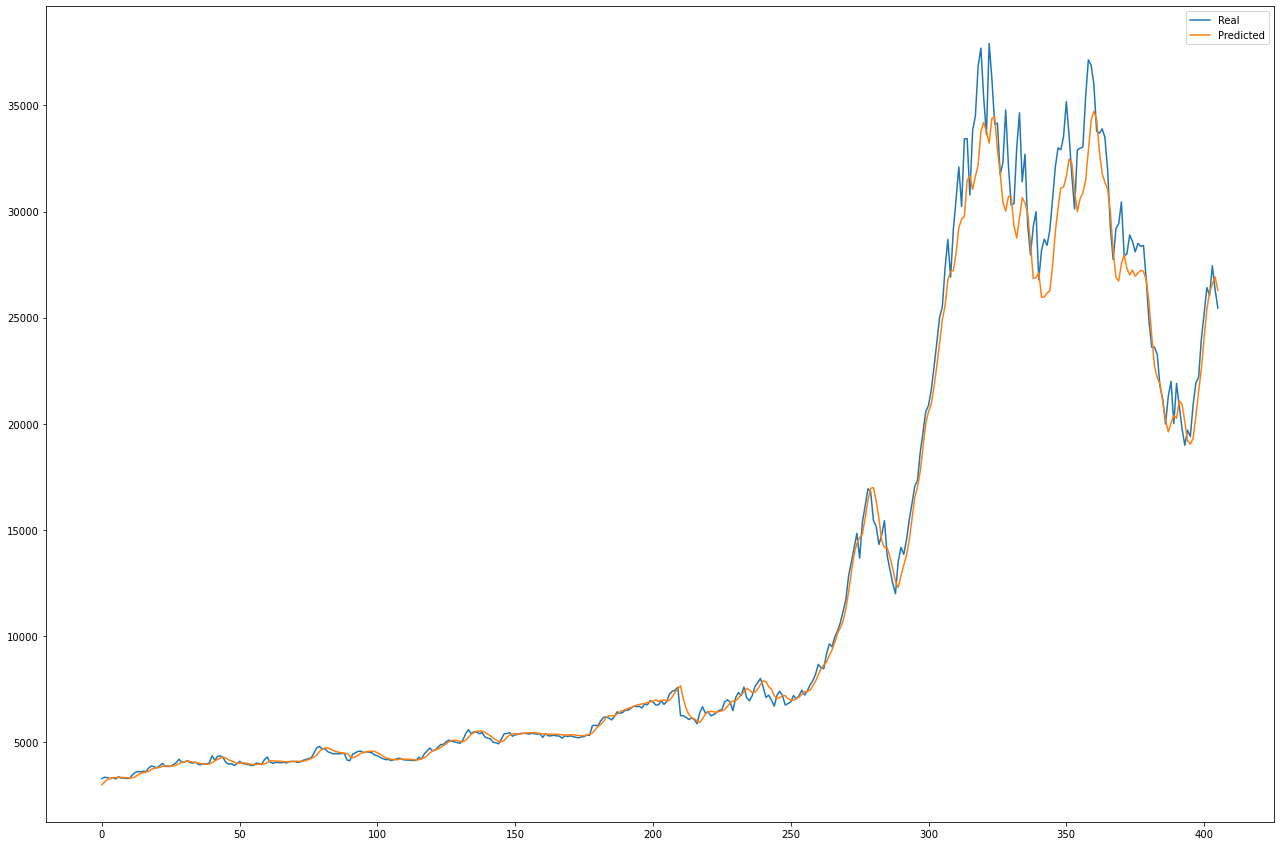

In [10]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()


> This model appears to not suffer the previous problem of being continuously off by a fixed amount, but does seem to suffer from not catching sudden jumps as well. Like at around x-coordinate 120, a large jump and dip in the real price occurs but the model fails to capture this effectively. But it is getting better! And it seems that technical indicators could be the way forward.
Let’s try including a more advanced technical indicator: the Moving Average Convergence Divergence. The MACD is calculated by subtracting the 26-period Exponential Moving Average from the 12-period EMA[6]. The EMA is calculated[7] using the formula:
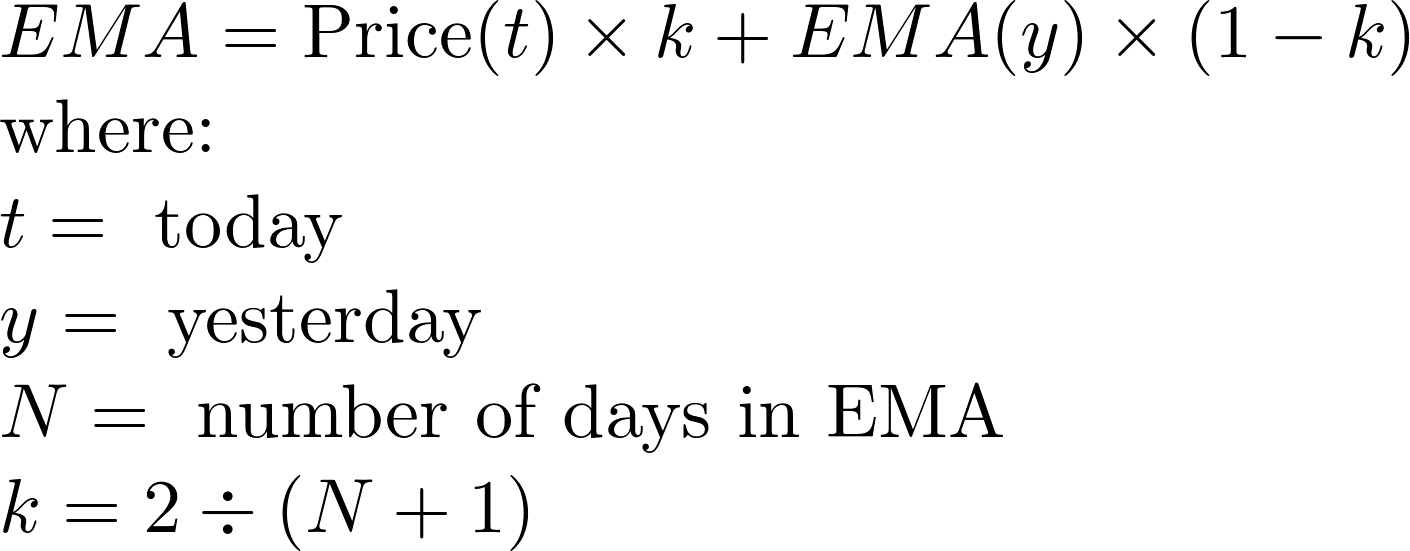

To update our technical indicators loop to include the MACD indicator:


In [11]:
def calc_ema(values, time_period):
    # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, [1, 2, 4]])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(len(values) - time_period, len(values)):
        close = values[i][4]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

In [12]:
import numpy as np
import pandas as pd
from sklearn import preprocessing


def preprocess(csv_path, history_points):
    data = pd.read_csv(csv_path)
    data = data.drop(columns=['date', 'adjClose', 'value', 'count'])
    data = data.drop(0, axis=0)
    data_np = data.to_numpy()
    """
    Train-Test-Validation Split
    """
    n1 = int(data_np.shape[0] * 0.7)
    n2 = int((data_np.shape[0] - n1) / 2)
    x_train = data_np[:n1]
    x_val = data_np[n1: n1 + n2]
    x_test = data_np[n1 + n2:]
    y_train_real = slicing(x_train, history_points)[1]
    y_train_real = np.expand_dims(y_train_real, -1)
    scale_back = preprocessing.MinMaxScaler()
    scale_back.fit(y_train_real)
    y_test_real = slicing(x_test, history_points)[1]

    minmax_scale = preprocessing.MinMaxScaler().fit(x_train)
    x_train_n = minmax_scale.transform(x_train)
    x_val_n = minmax_scale.transform(x_val)
    x_test_n = minmax_scale.transform(x_test)

    ohlvc_train, y_train = slicing(x_train_n, history_points)
    x_val_n, y_val = slicing(x_val_n, history_points)
    ohlvc_test, y_test = slicing(x_test_n, history_points)
    y_train = np.expand_dims(y_train, -1)

    """
    Technical Indicators
    """
    x_train_ind = slicing(x_train, history_points)[0]
    tech_ind_train = []
    for his in x_train_ind:
        # since I'm using his[1,2,4], I'm taking the SMA of the high, low ,closing price
        sma = np.mean(his[:, [1, 2, 4]])
        # 12 and 26 is the default values for ema in MACD indicator
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        tech_ind_train.append(np.array([sma, macd]))

    x_test_ind = slicing(x_test, history_points)[0]
    tech_ind_test = []
    for his in x_test_ind:
        sma = np.mean(his[:, [1, 2, 4]])
        # 12 and 26 is the default values for ema in MACD indicator
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        tech_ind_test.append(np.array([sma, macd]))

    x_val_ind = slicing(x_val, history_points)[0]
    tech_ind_val = []
    for his in x_val_ind:
        sma = np.mean(his[:, [1, 2, 4]])
        # 12 and 26 is the default values for ema in MACD indicator
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        tech_ind_val.append(np.array([sma, macd]))

    tech_ind_scaler = preprocessing.MinMaxScaler().fit(tech_ind_train)
    tech_ind_train = tech_ind_scaler.transform(tech_ind_train)
    tech_ind_test = tech_ind_scaler.transform(tech_ind_test)
    tech_ind_val = tech_ind_scaler.transform(tech_ind_val)

    tech_ind_train = np.array(tech_ind_train)
    tech_ind_test = np.array(tech_ind_test)
    tech_ind_val = np.array(tech_ind_val)

    assert ohlvc_train.shape[0] == y_train.shape[0] == tech_ind_train.shape[0]
    return ohlvc_train, y_train, ohlvc_test, y_test, x_val_n, y_val, y_test_real, scale_back, tech_ind_train, tech_ind_test, tech_ind_val


def slicing(data, history_points):
    # using the last {history_points} open high low close volume data points, predict the next open value
    ohlvc_histories = np.array(
        [data[i: i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.array(
        [data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])

    return ohlvc_histories, next_day_open_values

In [13]:
csv_path = '../input/national-iranian-copper-industries-co-stocks/femeli-daily.csv'
history_points = 50

x_train, y_train, x_test, y_test, x_val, y_val, y_test_real, scale_back, tech_ind_train, tech_ind_test, tech_ind_val = preprocess(csv_path, history_points)

In [14]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
from keras.callbacks import ModelCheckpoint

np.random.seed(4)

tf.random.set_seed(4)

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(tech_ind_train.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch operates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.v2.png', show_shapes=True)

# Fitting model
mcp_save = ModelCheckpoint('./stocks_price.h5', save_best_only=True, monitor='val_loss', mode='min')

model.fit(x=[x_train,tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True,validation_data=([x_val, tech_ind_val], y_val), callbacks=[mcp_save], verbose=0)
model.load_weights('./stocks_price.h5')

# Evaluate model (scaled data)
evaluation = model.evaluate([x_test, tech_ind_test], y_test)
print("Prediction Error for normalized data : {}".format(evaluation))

# Evaluate model (unscaled data)
y_test_predicted = model.predict([x_test, tech_ind_test])
y_test_predicted = scale_back.inverse_transform(y_test_predicted)
rmse = np.square(np.mean(y_test_real - y_test_predicted))
scaled_rmse = rmse / (np.max(y_test_real) - np.min(y_test_real)) * 100

print("Adjucted Prediction Root Mean Squared Error for real data : {} % ".format(scaled_rmse))

13/13 [==============================] - 0s 2ms/step - loss: 0.0048
Prediction Error for normalized data : 0.004823130089789629
Adjucted Prediction Root Mean Squared Error for real data : 298.46698851674273 % 


I got a final evaluation score of 0.004, which seems super low but remember that this is the mean squared error of the normalised data. After scaling this value will go up significantly, so it’s not a great metric for loss.

And I get an adjusted mean squared error of 298%! Much lower, and the prediction appears to fit significantly closer to the test set when plotted:

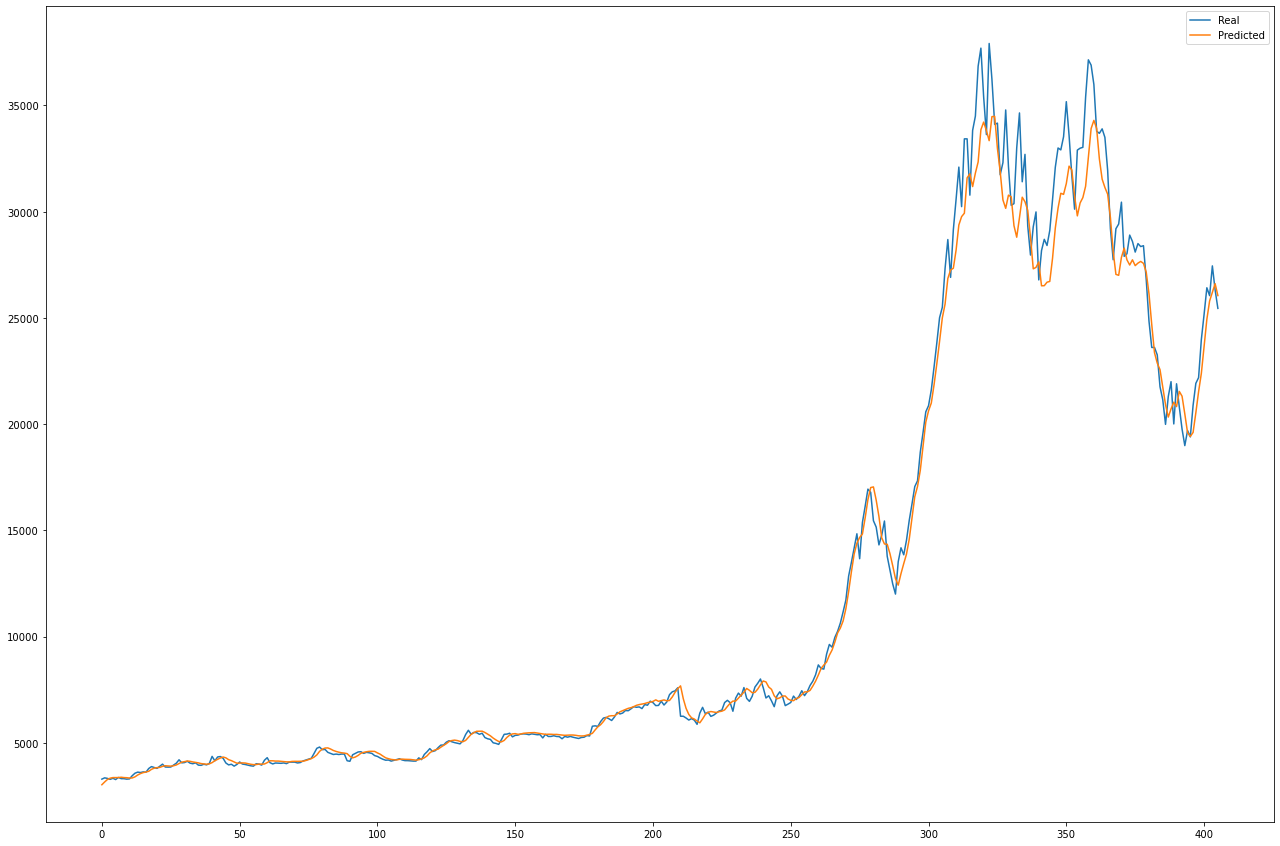

In [15]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

# The Algorithm
Armed with an okay-ish stock prediction algorithm I thought of a naïve way of creating a bot to decide to buy/sell a stock today given the stock’s history. In essence you just predict the opening value of the stock for the next day, and if it is beyond a threshold amount you buy the stock. If it is below another threshold amount, sell the stock. This dead simple algorithm actually seemed to work quite well — visually at least.

In [16]:
buys = []
sells = []
thresh = 1.005

x = 0
for ohlcv, ind in zip(x_test, tech_ind_test):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = scale_back.inverse_transform(normalised_price_today)
    predicted = np.squeeze(scale_back.inverse_transform(model.predict([np.array([ohlcv]), np.array([ind])])))
    delta = predicted / price_today
    if delta > thresh:
        buys.append((x, price_today[0][0]))
    elif delta < thresh:
        sells.append((x, price_today[0][0]))
    x += 1

Then plot the trades.

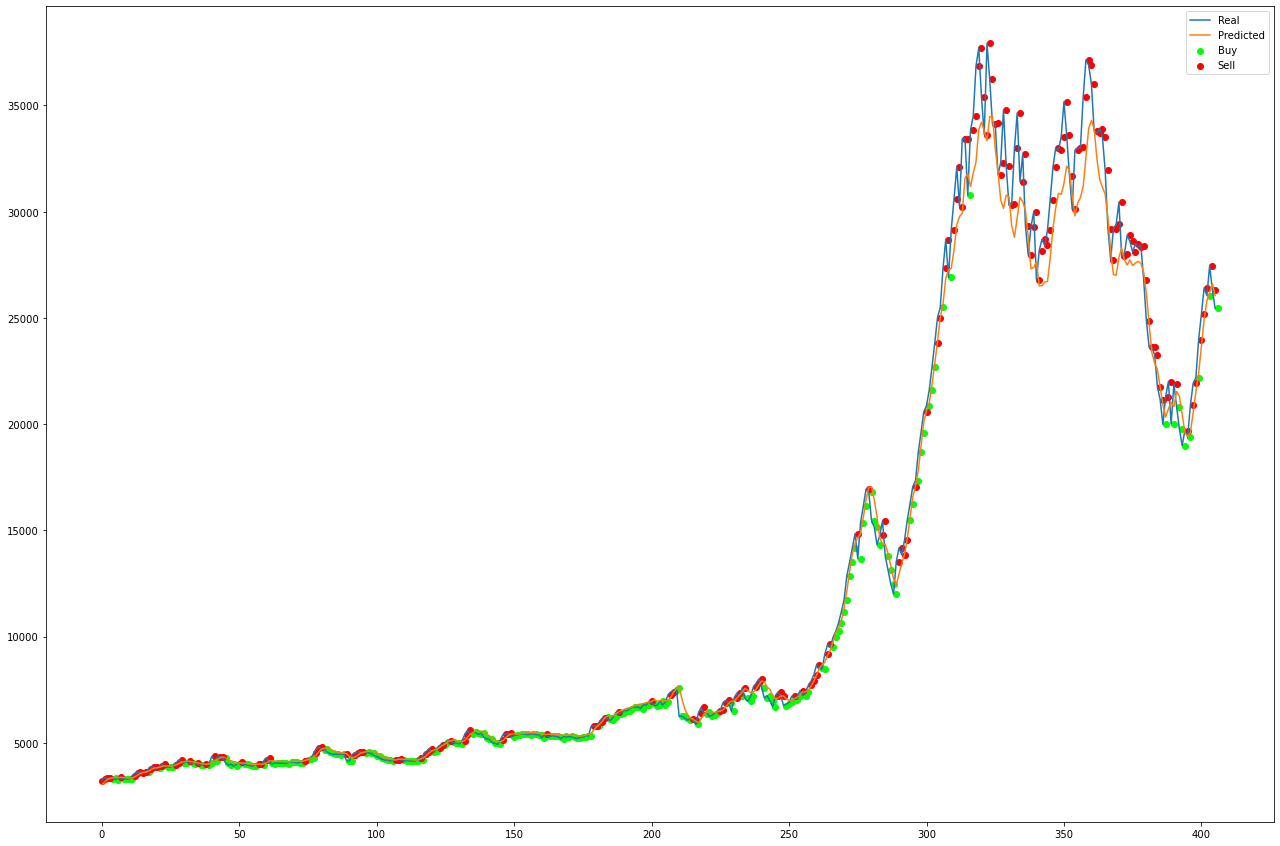

In [17]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00',label='Buy')
plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', label='Sell')



plt.legend(['Real', 'Predicted','Buy','Sell'])

plt.show()

Given these buys and sells, if we say that at each ‘buy’ we buy up 10 million Rials worth of the stock, and at each ‘sell’ we sell all of the stock, the algorithm would have earned about 95 million Rials. But bear in mind that is across 500 days. The code to calculate the earnings of the algorithm is here;

In [18]:
def compute_earnings(buys, sells):
    purchase_amt = 10000000 # 1 million toman
    stock = 0
    balance = 0
    while len(buys) > 0 and len(sells) > 0:
        if buys[0][0] < sells[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys[0][1]
            buys.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells[0][1]
            stock = 0
            sells.pop(0)
    print(balance)

print(compute_earnings(buys,sells))

95243050.28469616
None


# The Conclusion
I think there is still some room for improvement for the prediction algorithm. Namely, the technical indicators used, history_points hyperparameter, buy/sell algorithm/hyperparameters and model architecture are all things that I would like to optimise in the future.

The full code for this project is available on my [GitHub](https://github.com/swmnnmt/Algorithmic-trading-with-artificial-intelligence.git). Feel free to leave any feedback/improvements over on the issues page!

I do plan to expand on this project some more, to really push the limits of what can be achieved using just numerical data to predict stocks. Keep up to date with what I’m doing on my GitHub!

# References

[1] : https://www.experfy.com/blog/the-future-of-algorithmic-trading

[2] : https://colah.github.io/posts/2015-08-Understanding-LSTMs/

[3] : https://jovianlin.io/why-is-normalization-important-in-neural-networks/

[4] : https://www.investopedia.com/terms/t/technicalindicator.asp

[5] : https://www.investopedia.com/terms/s/sma.asp

[6] : https://www.investopedia.com/terms/m/macd.asp

[7] : https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp